# Pneumonia Identification from X-rays

#### Import the necessary Libraries 

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os
import glob

In [75]:
tf.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [76]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [77]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6765660689892976728
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3495673856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5806862498539620869
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


### Loading the data 

In [78]:
# Initial Dataset  

def process_img(img, label):
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    return img, label

train_ds = image_dataset_from_directory(
    'train',
    labels='inferred',
    shuffle=True,
    batch_size=32,
    image_size=(256,256),
    color_mode='rgb',
    label_mode='binary',
    interpolation='nearest'
).map(process_img)

test_ds = image_dataset_from_directory(
    'test',
    labels='inferred',
    shuffle=False,
    batch_size=32,
    image_size=(256,256),
    color_mode='rgb',
    label_mode='binary',
    interpolation='nearest'
).map(process_img)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [79]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)

Image shape:  (32, 256, 256, 3)


In [80]:
# import to RGB

#customize function used for color convetion
def RGB(image):
    converted_img = tf.io.decode_image(image, expand_animations = False, dtype=tf.float32, channels=3)
    return converted_img

In [81]:
# Import train and validation set 
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  shear_range=0.2,
                                                                  zoom_range=0.2,
                                                                  horizontal_flip=True,
                                                                  rotation_range = 30,
                                                                  vertical_flip=True,
                                                                 # preprocessing_function=RGB,
                                                                  validation_split=0.20)

train_data_gen = image_generator.flow_from_directory(directory='train',
                                                     target_size=(224, 224),
                                                     color_mode="rgb",
                                                     class_mode='binary',
                                                     batch_size=32,
                                                     shuffle=True,
                                                     subset='training')


val_data_gen = image_generator.flow_from_directory(directory='train',
                                                     target_size=(224, 224),
                                                     color_mode="rgb",
                                                     class_mode='binary',
                                                     batch_size=32,
                                                     shuffle=False,
                                                     subset='validation')

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [82]:
# Import test set 
image_generator2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_data_gen = image_generator2.flow_from_directory(directory='test', 
                                                    target_size=(224, 224),
                                                    color_mode="rgb",
                                                    class_mode='binary',
                                                    batch_size=32,
                                                    shuffle=False)


Found 624 images belonging to 2 classes.


##### Count Classes in training set 

In [83]:
filenames = tf.io.gfile.glob(str(os.getcwd() + '/train/*/*'))

Normal = len([filename for filename in filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(Normal))

Pneumonia = len([filename for filename in filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(Pneumonia))

Normal images count in training set: 1341
Pneumonia images count in training set: 3875


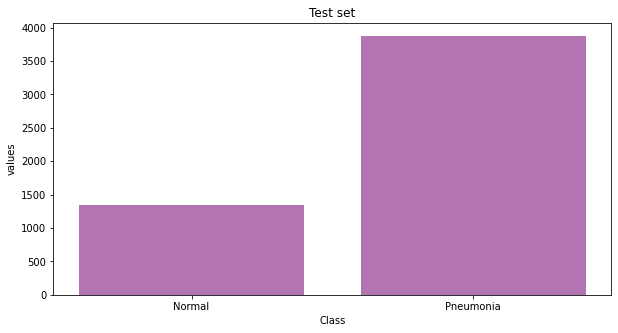

In [9]:
plt.figure(figsize=(10,5))

# create dataset
height = [Normal, Pneumonia]
bars = ('Normal', 'Pneumonia')

 
# Create bars and choose color
plt.bar(bars, height, color = (0.5,0.1,0.5,0.6))
 
# Add title and axis names
plt.title('Test set')
plt.xlabel('Class')
plt.ylabel('values')
 
# Show graph
plt.show()

The dataset is imbalanced and thus we are going to treat this problem by changing the weights 

In [42]:
# Calculate the weights 
weight_Normal = (1 / Normal)*(Normal + Pneumonia)/2.0 
weight_Pneumonia = (1 / Pneumonia)*(Normal + Pneumonia)/2.0

class_weight = {0: weight_Normal, 1: weight_Pneumonia}


"""
We calculate the weight based on the initial dataset, before splitting the train into train and validation sets.
However, since we performed a stratified spliti the balance between the classes remained the same
"""


print('Weight for Normal: {:.2f}'.format(weight_Normal))
print('Weight for Pneumonia: {:.2f}'.format(weight_Pneumonia))

Weight for Normal: 1.94
Weight for Pneumonia: 0.67


### Visualize the data 

We plot some cases from both classes from the initial training dataset 

In [19]:
"""
Make some transformations for plotting the images with the classification
"""


# define the data paths
train_normal_dir = 'train/NORMAL/'
train_pneu_dir = 'train/PNEUMONIA/'

# find all files, our files has extension jpeg
train_normal = glob.glob(train_normal_dir + '*jpeg')
train_pneu = glob.glob(train_pneu_dir + '*jpeg')


train_list = []

for x in train_normal:
    train_list.append([x, 0])
    
for x in train_pneu:
    train_list.append([x, 1])
    
    
# create a dataframe with the train data
train_df = pd.DataFrame(train_list, columns=['image', 'label'])   


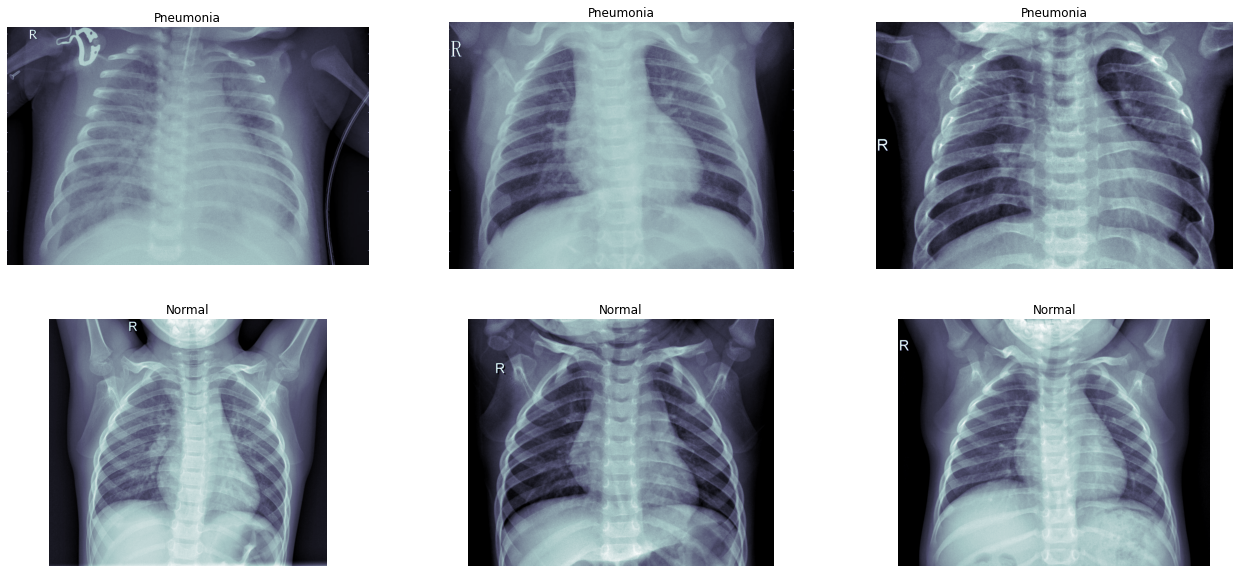

In [24]:
plt.figure(figsize=(22,10))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:3]['image']):
    plt.subplot(2,3,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='bone')
    plt.title('Pneumonia')
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:3]['image']):
    plt.subplot(2,3,3+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='bone')
    plt.title('Normal')

Since we are not expert we cannot see a clear pattern to recognize whether the patient has pneumonia or not. Let's hope CNNs could do a better job than us.

### Depth-wise convolution model 

In [86]:
# Model Creation 

def DWCNN():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    # Convolution layer 
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = tf.keras.layers.MaxPooling2D((2,2), name='pool1')(x)
    
    #1st seperable convolution layer
    x = tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = tf.keras.layers.MaxPooling2D((2,2), name='pool2')(x)
    #2nd seperable convolution layer
    x = tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = tf.keras.layers.BatchNormalization(name='bn1')(x)
    x = tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = tf.keras.layers.BatchNormalization(name='bn2')(x)
    x = tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = tf.keras.layers.MaxPooling2D((2,2), name='pool3')(x)
    #3rd seperable convolution layer
    x = tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = tf.keras.layers.BatchNormalization(name='bn3')(x)
    x = tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = tf.keras.layers.BatchNormalization(name='bn4')(x)
    x = tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = tf.keras.layers.MaxPooling2D((2,2), name='pool4')(x)
    #4th seperable convolution layer
    x = tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv5_1')(x)
    x = tf.keras.layers.BatchNormalization(name='bn5')(x)
    x = tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv5_2')(x)
    x = tf.keras.layers.BatchNormalization(name='bn6')(x)
    x = tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv5_3')(x)
    x = tf.keras.layers.MaxPooling2D((2,2), name='pool5')(x)  
    # Fully connected layers 
    x = tf.keras.layers.Flatten(name='flatten')(x)
    x = tf.keras.layers.Dense(512, activation='relu', name='fc1')(x)
    x = tf.keras.layers.Dropout(0.7, name='dropout1')(x)
    x = tf.keras.layers.Dense(256, activation='relu', name='fc2')(x)
    x = tf.keras.layers.Dropout(0.5, name='dropout2')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )        
    
    return model

In [98]:
model = DWCNN()
model.summary()

In [75]:
# Callbacks 

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.2, min_lr=0.00001)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("DWCNN.h5",save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=13,restore_best_weights=True)


In [76]:
history = model.fit(
    train_data_gen,
    batch_size = 32,
    epochs = 100 , 
    validation_data = val_data_gen,
    class_weight = class_weight,
    callbacks = [learning_rate_reduction, checkpoint_cb, early_stopping_cb])

Epoch 1/100
131/131 [==============================] - 90s 603ms/step - loss: 0.6939 - accuracy: 0.5440 - val_loss: 0.6882 - val_accuracy: 0.7430
Epoch 2/100
131/131 [==============================] - 72s 549ms/step - loss: 0.5176 - accuracy: 0.7366 - val_loss: 0.6825 - val_accuracy: 0.7430
Epoch 3/100
131/131 [==============================] - 75s 568ms/step - loss: 0.3405 - accuracy: 0.8665 - val_loss: 0.5561 - val_accuracy: 0.7430

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/100
131/131 [==============================] - 76s 575ms/step - loss: 0.2691 - accuracy: 0.8831 - val_loss: 0.6322 - val_accuracy: 0.7430
Epoch 5/100
131/131 [==============================] - 77s 582ms/step - loss: 0.2407 - accuracy: 0.9073 - val_loss: 0.3500 - val_accuracy: 0.7948
Epoch 6/100
131/131 [==============================] - 74s 561ms/step - loss: 0.2127 - accuracy: 0.9207 - val_loss: 0.1927 - val_accuracy: 0.9300
Epoch 7/100
131/131 [=====================

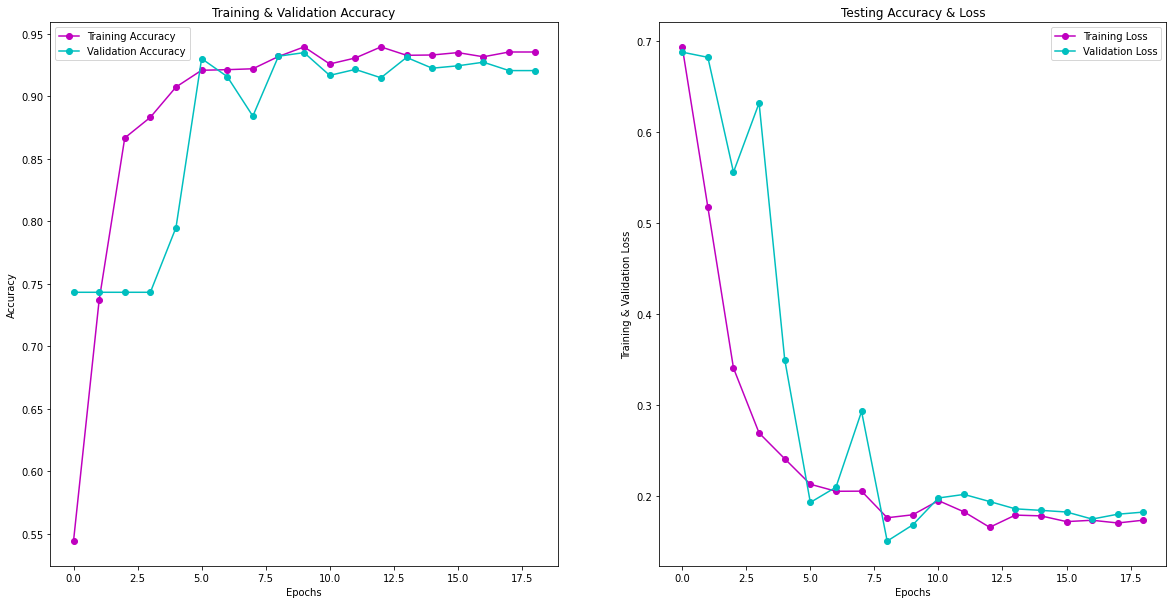

In [77]:
epochs = [i for i in range(19)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'mo-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'co-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")


ax[1].plot(epochs , train_loss , 'm-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'c-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")


plt.show()

In [3]:
model = tf.keras.models.load_model('DWCNN.h5')

In [7]:
 test_loss , test_accuracy = model.evaluate(test_data_gen)

20/20 [==============================] - 12s 230ms/step - loss: 0.3488 - accuracy: 0.8814


In [68]:
def preds(predictions):
    for i, j in enumerate(predictions): 

        x = np.empty([predictions.shape[0]])

        if j>0.5:
            x[i]=int(1)
        else:
            x[i]=int(0)
    return x.astype(int)

In [69]:
# Make predictions 
predictions = model.predict(test_data_gen)

predictions = preds(predictions)


y_test = test_data_gen.classes


print(classification_report(y_test, predictions, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))



                     precision    recall  f1-score   support

   Normal (Class 0)       0.50      0.87      0.63       234
Pneumonia (Class 1)       0.86      0.47      0.61       390

           accuracy                           0.62       624
          macro avg       0.68      0.67      0.62       624
       weighted avg       0.72      0.62      0.62       624



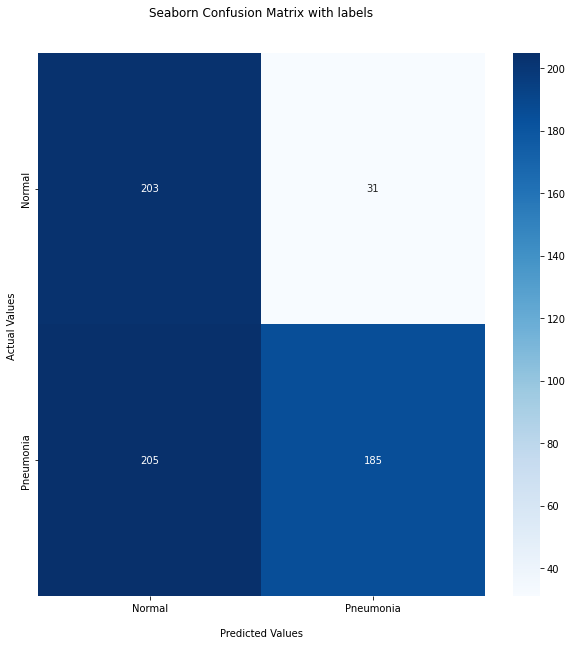

In [70]:
plt.figure(figsize = (10,10))

cm = confusion_matrix(y_test,predictions)

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Normal','Pneumonia'])
ax.yaxis.set_ticklabels(['Normal','Pneumonia'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [71]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Recall of the model is 0.47
Precision of the model is 0.86
F1 Score of the model is 0.61
